# MSAEXP pipeline data reduction steps for an example dataset from GO-2561 (UNCOVER)

*Pipeline steps*
1. Run the preprocessing pipline through extracting 2D cutouts
1. Combine and rectify the cutouts to a final stack
1. Extract 1D spectrum
1. fit redshift, line fluxes, etc. go to ``s2_specAnalysis.ipynb``

In [1]:
# CRDS variables
import os
if 'CRDS_PATH' not in os.environ is None:
    os.environ['CRDS_PATH'] = f'{os.getcwd()}/crds_cache'

    if not os.path.exists(os.environ['CRDS_PATH']):
        os.makedirs(os.environ['CRDS_PATH'])

'''Import CRDS Server to environmental variable'''
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

'''your CRDS path, if you haven't done that in your shell profile'''
os.environ['CRDS_PATH'] =  '/class_data/crds_cache'

'''HTTP proxy to visit internet'''
os.environ['http_proxy']  = 'http://192.168.101.206:3128'
os.environ['https_proxy'] = 'http://192.168.101.206:3128'

'''CRDS context, so we do not connect to CRDS server and download latest data'''
os.environ['CRDS_CONTEXT'] = 'jwst_1364.pmap'

In [2]:
import os
import glob
import yaml
import warnings
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
import jwst.datamodels
import jwst

import mastquery.jwst

import msaexp
from msaexp import pipeline
import msaexp.slit_combine
from msaexp import utils as msautils
from msaexp import msa

print(f'jwst version = {jwst.__version__}')
print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')

plt.rcParams['scatter.marker'] = '.'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['grid.linestyle'] = ':'

jwst version = 1.16.1
grizli version = 1.12.15
msaexp version = 0.9.8


In [3]:
# set up directories

prog = 2561
progstr = 'jw02561'
rootdir = '/data/go2561_uncover/DR250710'    # change to your own working directory
datadir = '/class_data/xwang/JDAP_NIRSpec/rate_maps'

if os.path.isdir(rootdir) == False:
    os.mkdir(rootdir)
os.chdir(rootdir)

outroot = 'uncover-v3'

In [ ]:
# copy rate maps from data folder

flist = glob.glob(os.path.join(datadir,f'{progstr}*fits'))
for f in flist:
    shutil.copy(f, './')

In [4]:
files = glob.glob(f'jw*rate.fits')

print(f' number of rate files:', len(files))
print(files)

 number of rate files: 17
['jw02561002003_03101_00002_nrs1_rate.fits', 'jw02561002003_03101_00003_nrs1_rate.fits', 'jw02561002003_03101_00004_nrs1_rate.fits', 'jw02561002003_03101_00005_nrs1_rate.fits', 'jw02561002003_03101_00006_nrs1_rate.fits', 'jw02561002003_03101_00007_nrs1_rate.fits', 'jw02561002003_05101_00001_nrs1_rate.fits', 'jw02561002003_05101_00002_nrs1_rate.fits', 'jw02561002003_05101_00003_nrs1_rate.fits', 'jw02561002003_05101_00004_nrs1_rate.fits', 'jw02561002003_05101_00005_nrs1_rate.fits', 'jw02561002003_05101_00006_nrs1_rate.fits', 'jw02561002003_07101_00001_nrs1_rate.fits', 'jw02561002003_07101_00002_nrs1_rate.fits', 'jw02561002003_07101_00003_nrs1_rate.fits', 'jw02561002003_07101_00004_nrs1_rate.fits', 'jw02561002003_07101_00005_nrs1_rate.fits']


In [21]:
# Unset DQ=4 pixels to avoid running ``snowblind`` for now
for file in files:
    with pyfits.open(file, mode='update') as im:
        im['DQ'].data -= (im['DQ'].data & 4)
        im.flush()

## Create target catalog and slit plots from the MSA meta file
For each mask, all the relevant info concerning MSA configuration is recorded in the `*_msa.fits` file, which is necessary to extract spectra for targets.

In [5]:
msafn = 'jw02561002003_01_msa.fits'
meta = msa.MSAMetafile(msafn)

# retrieve source catalog from MSA meta file
cat = meta.make_summary_table(image_path=None)

# write out a region file for all slits
reg = meta.regions_from_metafile(as_string=True, with_bars=True)
with open(msafn.replace('.fits','0.reg'), "w", encoding="ascii") as f:
    f.write(reg)


We select the following two sources for this practice:

- A2744-QSO1 [Furtak et al. (2024)](https://www.nature.com/articles/s41586-024-07184-8)
- A strongly lensed arc at z=4 (see [Vanzella et al. (2022)](https://iopscience.iop.org/article/10.3847/2041-8213/ac8c2d) and [Lin et al. (2023)](https://iopscience.iop.org/article/10.3847/2041-8213/aca1c4))


In [6]:
# identify target IDs using crossmatch
# in this example, we select two sources: A2744-QSO and z4arc

targets = utils.GTable()
targets['id']  = np.array(['A2744-QSO1', 'z4arc'])
targets['ra']  = np.array([3.5798408,     3.589089])
targets['dec'] = np.array([-30.4015681,  -30.393844])

idx, dr = cat.match_to_catalog_sky(targets)
indices = []
for i, n in enumerate(idx):
    if dr[i].value > 1.:
        print(targets['id'][i], ' not matched...')
        continue
    else:
        indices.append(i)

obj = utils.GTable()
obj['id'] = cat['source_id'][idx][indices]
obj['ra'] = targets['ra'][indices]
obj['dec'] = targets['dec'][indices]
obj['idx'] = idx[indices]
obj['dr'] = dr[indices]  # .to(u.mas)
obj['dr'].format = '0.2f'
obj['name'] = targets['id'][indices]

print(obj)


  id      ra        dec     idx   dr      name   
         deg        deg         arcsec           
----- --------- ----------- --- ------ ----------
13123 3.5798408 -30.4015681   5   0.04 A2744-QSO1
17467  3.589089  -30.393844  20   0.97      z4arc


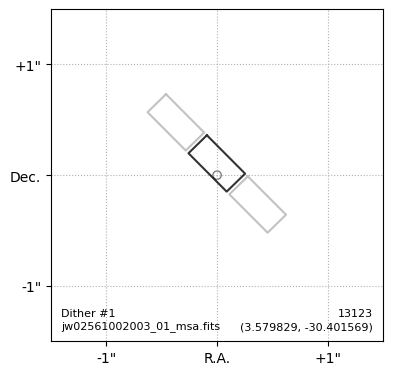

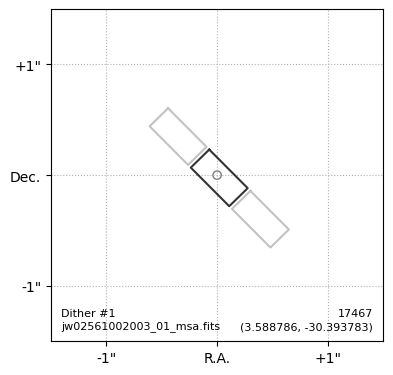

In [7]:
sources_selected = obj['id'].data.tolist()

for id in sources_selected:
    meta.plot_slitlet(source_id=id,dither_point_index=1)

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [BarShadowStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.barshadow.BarShadowStep.html#jwst.barshadow.BarShadowStep) : Bar Shadow
        - See also [MSAEXP PR#66](https://github.com/gbrammer/msaexp/pull/66)
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout `SlitModel` files of the last pipeline step performed (`phot` = `PhotomStep`)

## Note! 

When the ``source_ids`` list is specified, the pipeline is only run for those sources in the MSA plan and will be much faster.  Set ``source_ids=None`` to extract *everything*.

In [8]:
redo_COMPLETED = True
source_ids = [13123,17467]
# Only include the example sources. or can you `None` to reduce data for all targets in the mask

for file in files:
    mode = '-'.join(file.split('_')[:4])
    im=pyfits.open(file)
    if  "MSAMETFL" in im[0].header:
        if (not os.path.exists(f'{mode}.slits.yaml')) or redo_COMPLETED:
            pipe = pipeline.NirspecPipeline(mode=mode, files=[file])
            pipe = pipeline.NirspecPipeline(mode=mode,
                                            files=[file],
                                            source_ids=source_ids,
                                            positive_ids=True # Ignore background slits
                                        ) 
            
            pipe.full_pipeline(run_extractions=False,
                            initialize_bkg=False,
                            load_saved=None,
                            scale_rnoise=True)
        else:
            print(f'Skip preprocessing: {mode}')
            continue
    else:
        print('The fits have not MSAMETFL in the header')
        continue

# (2025-07-10 01:27:14.503)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:27:14.883)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-10 01:27:16.019)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:27:16.023)
msaexp.preprocess : set CRDS_CTX=jwst_1364.pmap
# (2025-07-10 01:27:16.024)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00002-nrs1', 'files': ['jw02561002003_03101_00002_nrs1_rat

2025-07-10 01:27:24,290 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:27:24,345 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:27:24,400 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:27:24,594 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:27:25.792)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-10 01:27:31.553)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-10 01:27:37.192)
msaexp.jwst.PathLossStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-10 01:27:38.253)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-10 01:27:39.954)
msaexp.jwst.PhotomStep: jw02561002003_03101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00002-nrs1
# Get slitlet data from jw02561002003-03101-00002-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:27:41,341 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:27:41,823 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:27:42,299 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:27:43,037 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:27:43,511 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:27:43,994 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:27:44,474 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:27:44,958 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:27:45,439 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:27:45,912 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:27:46.350)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:27:46.726)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-10 01:27:47.850)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:27:47.852)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00003-nrs1', 'files': ['jw02561002003_03101_00003_nrs1

2025-07-10 01:27:53,028 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:27:53,081 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:27:53,133 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:27:53,317 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:27:54.473)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-10 01:28:00.281)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-10 01:28:04.458)
msaexp.jwst.PathLossStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-10 01:28:05.580)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-10 01:28:07.346)
msaexp.jwst.PhotomStep: jw02561002003_03101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00003-nrs1
# Get slitlet data from jw02561002003-03101-00003-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:28:08,792 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:28:09,268 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:28:09,752 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:28:10,533 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:28:11,029 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:28:11,527 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:28:12,021 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:28:12,504 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:28:12,985 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:28:13,465 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:28:13.907)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:28:14.293)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-10 01:28:15.439)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:28:15.442)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00004-nrs1', 'files': ['jw02561002003_03101_00004_nrs1

2025-07-10 01:28:20,615 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:28:20,668 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:28:20,723 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:28:20,921 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:28:22.132)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-10 01:28:28.171)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-10 01:28:32.181)
msaexp.jwst.PathLossStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-10 01:28:33.251)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-10 01:28:34.985)
msaexp.jwst.PhotomStep: jw02561002003_03101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00004-nrs1
# Get slitlet data from jw02561002003-03101-00004-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:28:36,446 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:28:36,923 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:28:37,400 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:28:38,206 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:28:38,706 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:28:39,208 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:28:39,705 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:28:40,188 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:28:40,670 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:28:41,147 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:28:41.596)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:28:41.980)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-10 01:28:43.134)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:28:43.136)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00005-nrs1', 'files': ['jw02561002003_03101_00005_nrs1

2025-07-10 01:28:48,348 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:28:48,404 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:28:48,456 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:28:48,646 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:28:49.838)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-10 01:28:55.644)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-10 01:28:59.823)
msaexp.jwst.PathLossStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-10 01:29:00.965)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-10 01:29:02.778)
msaexp.jwst.PhotomStep: jw02561002003_03101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00005-nrs1
# Get slitlet data from jw02561002003-03101-00005-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:29:04,259 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:29:04,736 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:29:05,209 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:29:05,987 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:29:06,459 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:29:06,932 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:29:07,403 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:29:07,871 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:29:08,339 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:29:08,804 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:29:09.230)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00006_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:29:09.606)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-10 01:29:10.730)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:29:10.732)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00006-nrs1', 'files': ['jw02561002003_03101_00006_nrs1

2025-07-10 01:29:16,023 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:29:16,079 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:29:16,133 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:29:16,327 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:29:17.544)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-10 01:29:23.370)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-10 01:29:27.508)
msaexp.jwst.PathLossStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-10 01:29:28.623)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-10 01:29:30.395)
msaexp.jwst.PhotomStep: jw02561002003_03101_00006_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00006-nrs1
# Get slitlet data from jw02561002003-03101-00006-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:29:31,851 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00006-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:29:32,337 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:29:32,823 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:29:33,653 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:29:34,136 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:29:34,625 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:29:35,121 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:29:35,615 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:29:36,105 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:29:36,592 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:29:37.040)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00007-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00007_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00007-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:29:37.417)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00007-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-10 01:29:38.547)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00007-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:29:38.550)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00007-nrs1', 'files': ['jw02561002003_03101_00007_nrs1

2025-07-10 01:29:43,798 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:29:43,851 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:29:43,902 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:29:44,087 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:29:45.258)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-10 01:29:51.037)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-10 01:29:55.310)
msaexp.jwst.PathLossStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-10 01:29:56.436)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-10 01:29:58.229)
msaexp.jwst.PhotomStep: jw02561002003_03101_00007_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00007-nrs1
# Get slitlet data from jw02561002003-03101-00007-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:29:59,712 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00007-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:30:00,195 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:30:00,670 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:30:01,526 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:30:02,021 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:30:02,507 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:30:02,994 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:30:03,478 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:30:03,963 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:30:04,443 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:30:04.889)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:30:05.271)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-10 01:30:06.426)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:30:06.429)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00001-nrs1', 'files': ['jw02561002003_05101_00001_nrs1

2025-07-10 01:30:11,634 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:30:11,690 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:30:11,743 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:30:11,940 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:30:13.167)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-10 01:30:18.968)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-10 01:30:22.992)
msaexp.jwst.PathLossStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-10 01:30:24.117)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-10 01:30:25.900)
msaexp.jwst.PhotomStep: jw02561002003_05101_00001_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00001-nrs1
# Get slitlet data from jw02561002003-05101-00001-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:30:27,372 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00001-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:30:27,860 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:30:28,349 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:30:29,180 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:30:29,668 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:30:30,161 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:30:30,672 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:30:31,159 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:30:31,649 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:30:32,128 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:30:32.564)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:30:32.951)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-10 01:30:34.115)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:30:34.118)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00002-nrs1', 'files': ['jw02561002003_05101_00002_nrs1

2025-07-10 01:30:39,409 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:30:39,463 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:30:39,516 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:30:39,710 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:30:40.930)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-10 01:30:46.805)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-10 01:30:51.040)
msaexp.jwst.PathLossStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-10 01:30:52.204)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-10 01:30:53.988)
msaexp.jwst.PhotomStep: jw02561002003_05101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00002-nrs1
# Get slitlet data from jw02561002003-05101-00002-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:30:55,411 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:30:55,878 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:30:56,344 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:30:57,134 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:30:57,606 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:30:58,082 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:30:58,574 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:30:59,059 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:30:59,546 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:31:00,032 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:31:00.476)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:31:00.853)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-10 01:31:01.988)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:31:01.991)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00003-nrs1', 'files': ['jw02561002003_05101_00003_nrs1

2025-07-10 01:31:07,404 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:31:07,458 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:31:07,511 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:31:07,703 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:31:08.907)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-10 01:31:14.732)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-10 01:31:18.895)
msaexp.jwst.PathLossStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-10 01:31:20.018)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-10 01:31:21.802)
msaexp.jwst.PhotomStep: jw02561002003_05101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00003-nrs1
# Get slitlet data from jw02561002003-05101-00003-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:31:23,294 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:31:23,784 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:31:24,271 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:31:25,119 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:31:25,613 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:31:26,112 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:31:26,610 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:31:27,105 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:31:27,597 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:31:28,087 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:31:28.533)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:31:28.913)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-10 01:31:30.041)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:31:30.043)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00004-nrs1', 'files': ['jw02561002003_05101_00004_nrs1

2025-07-10 01:31:35,162 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:31:35,218 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:31:35,271 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:31:35,466 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:31:36.693)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-10 01:31:42.586)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-10 01:31:46.774)
msaexp.jwst.PathLossStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-10 01:31:47.922)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-10 01:31:49.706)
msaexp.jwst.PhotomStep: jw02561002003_05101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00004-nrs1
# Get slitlet data from jw02561002003-05101-00004-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:31:51,174 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:31:51,723 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:31:52,204 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:31:53,015 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:31:53,501 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:31:53,984 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:31:54,473 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:31:54,953 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:31:55,430 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:31:55,904 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:31:56.346)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:31:56.735)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-10 01:31:57.865)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:31:57.868)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00005-nrs1', 'files': ['jw02561002003_05101_00005_nrs1

2025-07-10 01:32:03,223 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:32:03,278 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:32:03,333 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:32:03,528 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:32:04.753)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-10 01:32:10.428)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-10 01:32:14.659)
msaexp.jwst.PathLossStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-10 01:32:15.834)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-10 01:32:17.628)
msaexp.jwst.PhotomStep: jw02561002003_05101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00005-nrs1
# Get slitlet data from jw02561002003-05101-00005-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:32:19,116 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:32:19,601 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:32:20,081 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:32:20,894 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:32:21,380 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:32:21,885 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:32:22,378 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:32:22,874 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:32:23,362 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:32:23,851 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:32:24.298)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00006_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:32:24.689)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-10 01:32:25.840)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:32:25.843)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00006-nrs1', 'files': ['jw02561002003_05101_00006_nrs1

2025-07-10 01:32:31,056 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:32:31,112 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:32:31,163 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:32:31,356 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:32:32.591)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-10 01:32:38.467)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-10 01:32:42.577)
msaexp.jwst.PathLossStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-10 01:32:43.666)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-10 01:32:45.389)
msaexp.jwst.PhotomStep: jw02561002003_05101_00006_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00006-nrs1
# Get slitlet data from jw02561002003-05101-00006-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:32:46,864 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00006-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:32:47,346 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:32:47,831 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:32:48,678 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:32:49,174 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:32:49,671 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:32:50,176 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:32:50,682 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:32:51,179 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:32:51,680 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:32:52.128)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:32:52.505)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-10 01:32:53.673)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:32:53.676)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00001-nrs1', 'files': ['jw02561002003_07101_00001_nrs1

2025-07-10 01:32:58,918 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:32:58,971 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:32:59,026 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:32:59,218 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:33:00.418)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-10 01:33:06.223)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-10 01:33:10.413)
msaexp.jwst.PathLossStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-10 01:33:11.567)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-10 01:33:13.376)
msaexp.jwst.PhotomStep: jw02561002003_07101_00001_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00001-nrs1
# Get slitlet data from jw02561002003-07101-00001-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:33:14,874 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00001-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:33:15,360 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:33:15,848 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:33:16,683 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:33:17,165 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:33:17,638 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:33:18,109 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:33:18,584 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:33:19,053 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:33:19,519 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:33:19.948)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:33:20.325)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-10 01:33:21.452)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:33:21.455)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00002-nrs1', 'files': ['jw02561002003_07101_00002_nrs1

2025-07-10 01:33:26,545 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:33:26,598 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:33:26,650 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:33:26,836 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:33:28.007)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-10 01:33:33.809)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-10 01:33:37.967)
msaexp.jwst.PathLossStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-10 01:33:39.092)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-10 01:33:40.910)
msaexp.jwst.PhotomStep: jw02561002003_07101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00002-nrs1
# Get slitlet data from jw02561002003-07101-00002-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:33:42,420 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:33:42,904 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:33:43,392 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:33:44,224 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:33:44,731 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:33:45,256 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:33:45,732 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:33:46,202 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:33:46,669 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:33:47,135 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:33:47.564)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:33:47.942)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-10 01:33:49.069)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:33:49.072)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00003-nrs1', 'files': ['jw02561002003_07101_00003_nrs1

2025-07-10 01:33:54,152 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:33:54,205 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:33:54,257 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:33:54,444 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:33:55.608)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-10 01:34:01.194)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-10 01:34:05.229)
msaexp.jwst.PathLossStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-10 01:34:06.325)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-10 01:34:08.098)
msaexp.jwst.PhotomStep: jw02561002003_07101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00003-nrs1
# Get slitlet data from jw02561002003-07101-00003-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:34:09,574 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:34:10,051 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:34:10,534 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:34:11,371 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:34:11,875 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:34:12,366 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:34:12,857 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:34:13,345 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:34:13,826 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:34:14,310 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:34:14.756)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:34:15.150)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-10 01:34:16.319)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:34:16.322)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00004-nrs1', 'files': ['jw02561002003_07101_00004_nrs1

2025-07-10 01:34:21,669 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:34:21,723 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:34:21,775 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:34:21,963 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:34:23.148)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-10 01:34:28.785)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-10 01:34:32.884)
msaexp.jwst.PathLossStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-10 01:34:33.983)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-10 01:34:35.717)
msaexp.jwst.PhotomStep: jw02561002003_07101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00004-nrs1
# Get slitlet data from jw02561002003-07101-00004-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:34:37,153 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:34:37,621 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:34:38,086 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:34:38,899 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:34:39,373 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:34:39,847 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:34:40,320 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:34:40,792 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:34:41,262 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:34:41,740 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-10 01:34:42.170)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-10 01:34:42.547)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-10 01:34:43.671)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 14411, 17467, 18924, 19981, 21834, 24531, 26882, 36678, 60157]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-10 01:34:43.673)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00005-nrs1', 'files': ['jw02561002003_07101_00005_nrs1

2025-07-10 01:34:48,783 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-10 01:34:48,838 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-10 01:34:48,891 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-10 01:34:49,080 - stpipe.MSAFlagOpenStep - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:94: RuntimeWarn

# (2025-07-10 01:34:50.270)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-10 01:34:55.938)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-10 01:34:59.996)
msaexp.jwst.PathLossStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-10 01:35:01.091)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-10 01:35:02.831)
msaexp.jwst.PhotomStep: jw02561002003_07101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00005-nrs1
# Get slitlet data from jw02561002003-07101-00005-nrs1.slits.yaml
   0    99   2561_36678  3.594799 -30.360729
   1   149   2561_26882  3.599382 -30.375944
   2   159   2561_24531  3.601343 -30.379199
   3   180   2561_60157  3.603847 -30.382238
   4   181   2561_21834  3.602081 -30.384282
   5   135   2561_19981  3.576806 -30.387981
   6   145   2561_18924  3.581044 -30.389561
   7   164   2561_14411  3.576619 -30.401801
   8 

2025-07-10 01:35:04,253 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.get_slit_traces: Trace set at index 0 for 2561_19981
msaexp.get_slit_traces: Trace set at index 0 for 2561_18924
msaexp.get_slit_traces: Trace set at index 0 for 2561_14411
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.099.2561_36678.fits 


2025-07-10 01:35:04,721 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.149.2561_26882.fits 


2025-07-10 01:35:05,186 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.159.2561_24531.fits 


2025-07-10 01:35:05,982 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.180.2561_60157.fits 


2025-07-10 01:35:06,454 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.181.2561_21834.fits 


2025-07-10 01:35:06,927 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.135.2561_19981.fits 


2025-07-10 01:35:07,399 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.145.2561_18924.fits 


2025-07-10 01:35:07,870 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.164.2561_14411.fits 


2025-07-10 01:35:08,340 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-10 01:35:08,812 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.176.2561_13123.fits 


In [9]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  ['wcs', 'open', '2d', 'flat', 'path', 'bar', 'phot']
Last step:  phot


In [35]:
# index of sources to extract
ind = 1
target=f'{prog}_{source_ids[ind]}'

phot_files = glob.glob(f'jw0*{source_ids[ind]}.fits')
phot_files.sort()

print('target: ', target)
print('Number of phot files: ', len(phot_files))
print('\n'.join(phot_files))

Number of phot files:  17
jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits


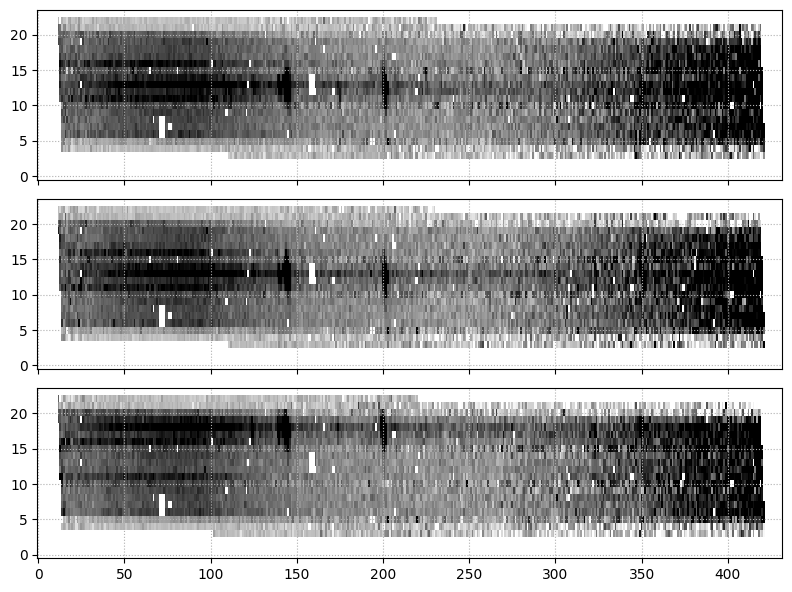

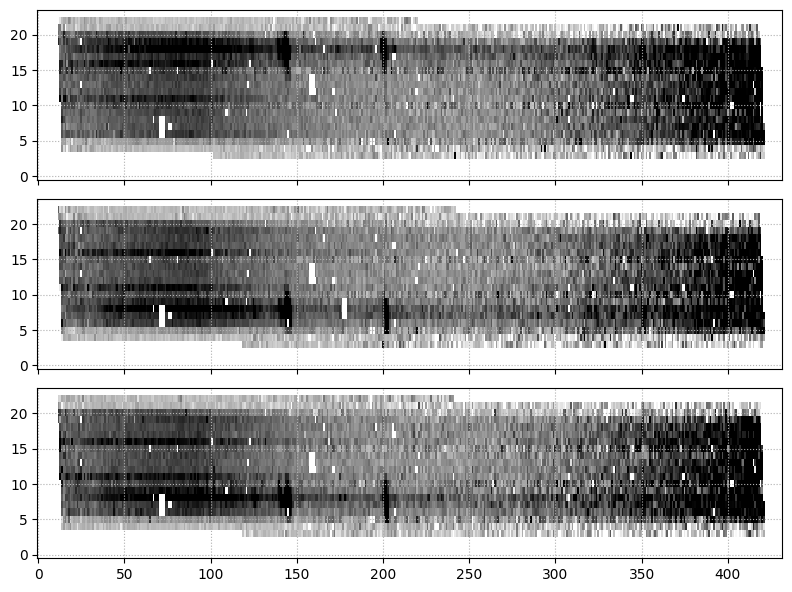

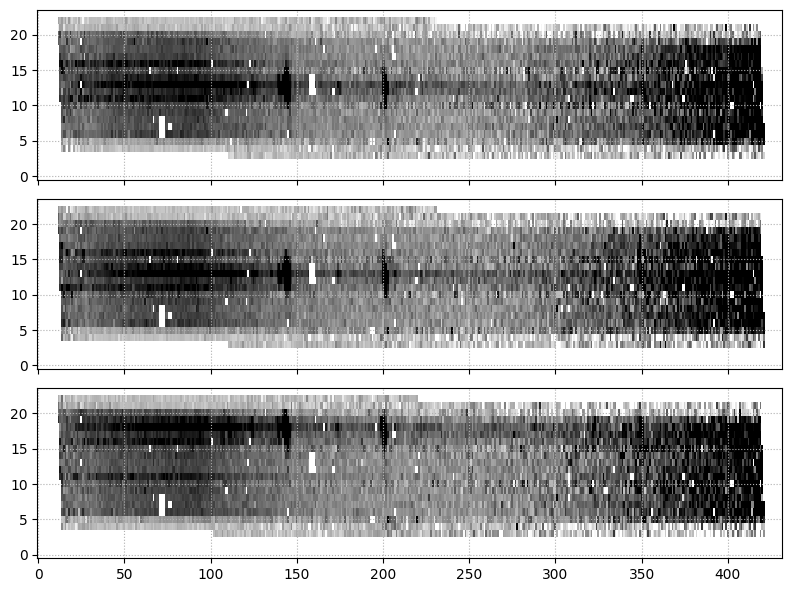

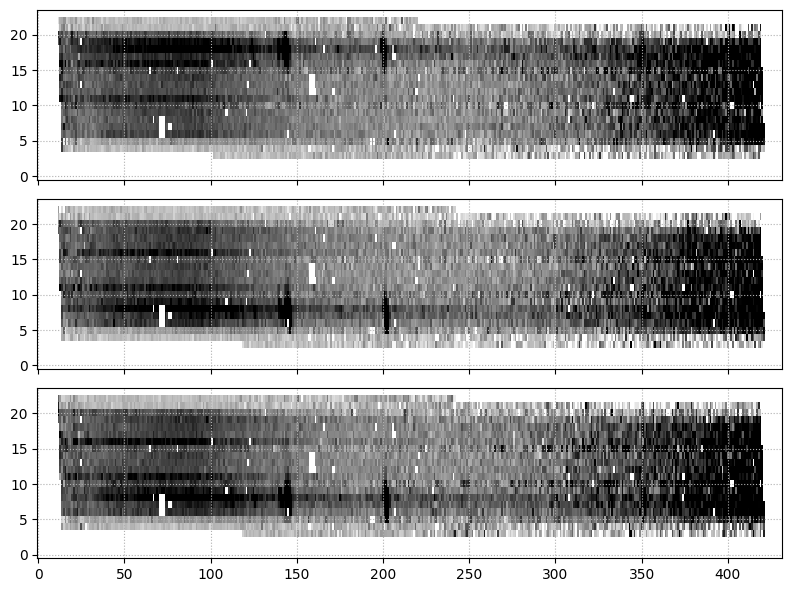

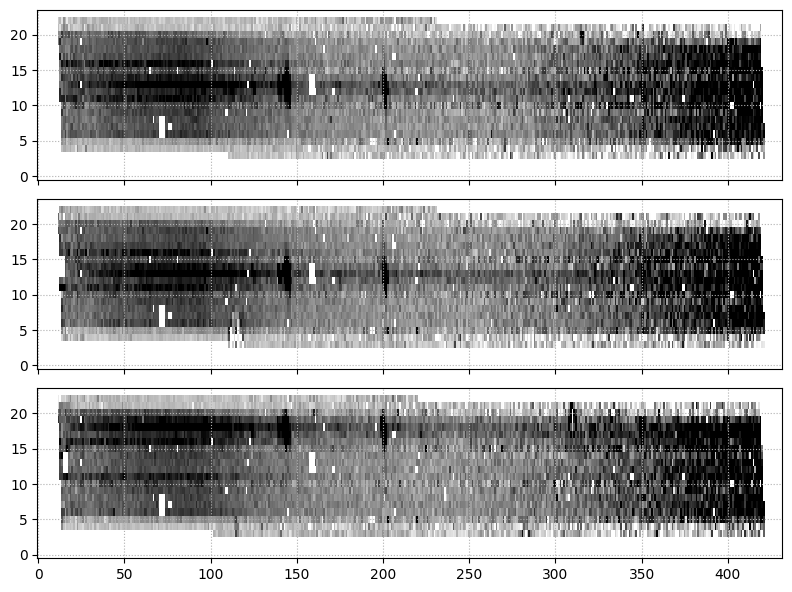

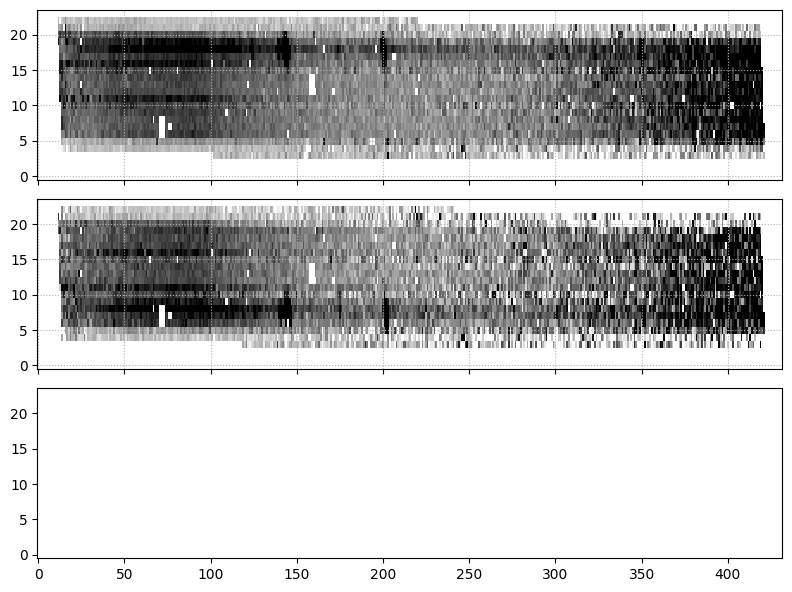

In [36]:
i=0
for i in range(6):
    
    fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True, sharey=True)
    
    for ax, file in zip(axes, phot_files[i*3:i*3+3]):
        dm = jwst.datamodels.open(file)
        ax.imshow(dm.data, vmin=-0.1, vmax=0.3,aspect='auto', cmap='gray_r')
        ax.grid()
        
    fig.tight_layout(pad=1)
    plt.show()

# Exposure combination and spectral extraction

In [37]:
group_kws = dict(
    diffs=True, # For nod differences
    undo_barshadow=2, # For msaexp barshadow correction
    min_bar=0.35, # minimum allowed value for the (inverse) bar shadow correction
    position_key="y_index",
    trace_with_ypos=True, # Include expected y shutter offset in the trace
    trace_from_yoffset=True,
    flag_profile_kwargs=None, # Turn off profile flag
)    

obj = msaexp.slit_combine.SlitGroup(
    phot_files,
    outroot,
    **group_kws,
)

2025-07-10 01:41:52,907 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

In [38]:
print(f"""
Number of exposures: {obj.N}
2D array shape: {obj.sh}
Flattened data array: {obj.sci.shape}
""")


Number of exposures: 17
2D array shape: (24, 432)
Flattened data array: (17, 10368)



Show the exposure data again now with the trace.

Also note that the sky is flatter than before with the updated bar shadow correction.

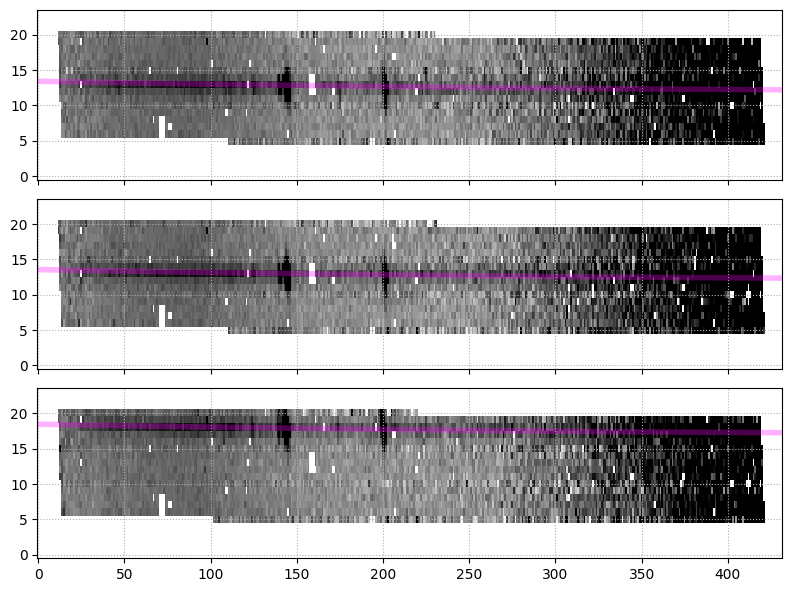

In [39]:
num = 3  # can set to obj.N to display all exposures

fig, axes = plt.subplots(num, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.sci[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Fit the trace profile

The profile is modeled as a (pixel-integrated) Gaussian with a specified width that is added in quadrature with the tabulated 
PSF width.

In [40]:
fit = obj.fit_all_traces(
    offset_degree=0, # order of the offset polynomial to fit
    force_positive=False,
    x0=[2, 0.], # Initial guess:  gaussian width in pixels x 10, trace offset pixels
    niter=1,
    ref_exp=obj.calc_reference_exposure
)

   fit_all_traces, iter 0
      75  sigma=2.00  [ 0.000]  9822.9
      76  sigma=3.15  [ 0.010]  9158.9
     Exposure group 2   dchi2 =    -664.0

      77  sigma=3.15  [ 0.010]  10289.8
      78  sigma=3.15  [ 0.010]  10289.8
     Exposure group 1   dchi2 =       0.0

      79  sigma=3.15  [ 0.010]  10156.1
      80  sigma=3.15  [ 0.010]  10156.1
     Exposure group 3   dchi2 =       0.0



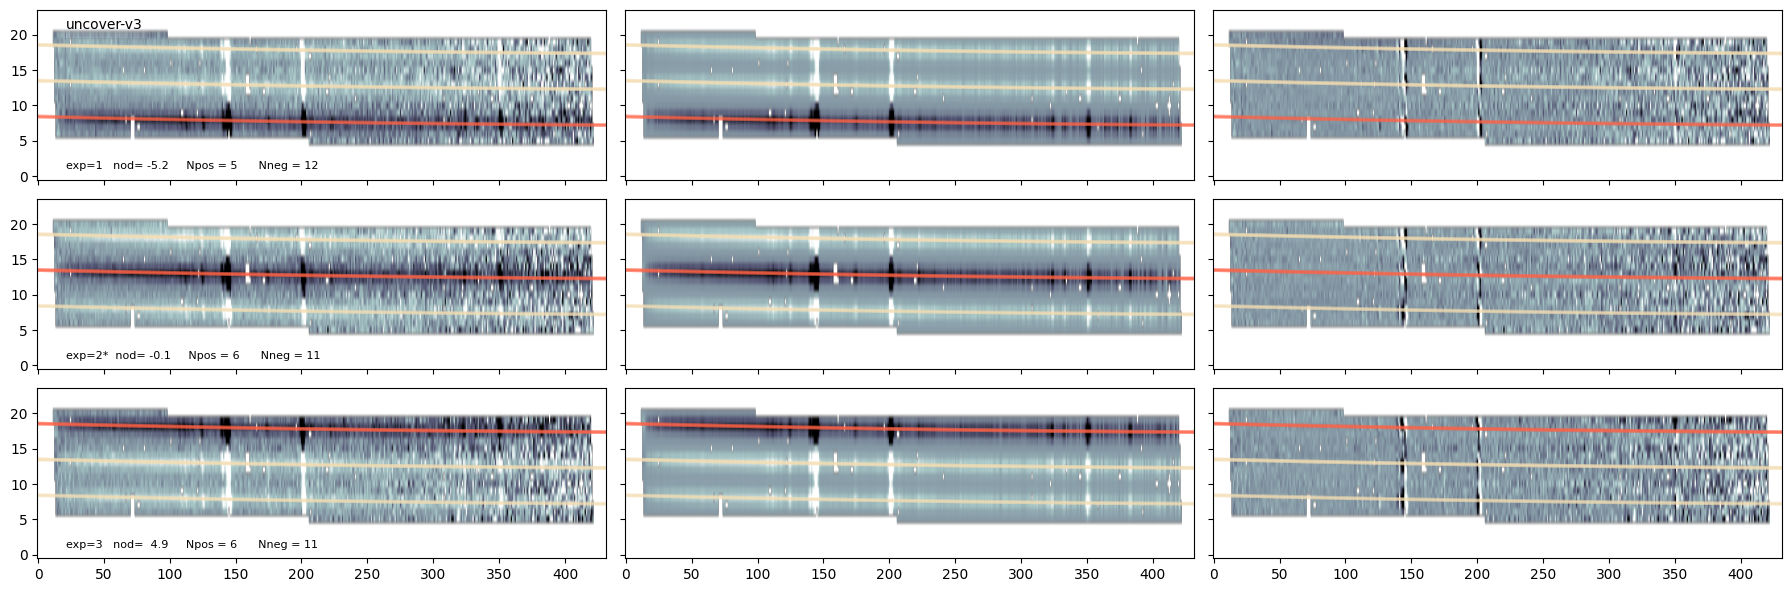

In [41]:
# Show the profile fit
fig2d = obj.plot_2d_differences(fit=fit)

# Resample the spectra to a rectified pixel grid and get optimal 1D extraction

In [42]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.31
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 29282.9
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.31


In [43]:
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    378   501R x 10C   ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']   
  2  SCI           1 ImageHDU       353   (501, 31)   float64   
  3  WHT           1 ImageHDU       353   (501, 31)   float64   
  4  PROFILE       1 ImageHDU       353   (501, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   ['D', 'D', 'D']   
  6  BACKGROUND    1 ImageHDU       353   (501, 31)   float64   
  7  PIXTAB        1 BinTableHDU     49   100812R x 13C   ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'K', 'D', 'D']   
  8  SLITS         1 BinTableHDU    107   17R x 49C   ['55A', 'K', 'K', 'D', 'D', 'D', 'D', 'D', 'K', '10A', 'D', 'D', 'D', 'D', '3A', 'K', 'K', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', '4A', '5A', '5A', '29A', 'K', 'K', 'D', 'K', 'K', 'K', '12A', 'D', 'D', 'D', 'D'

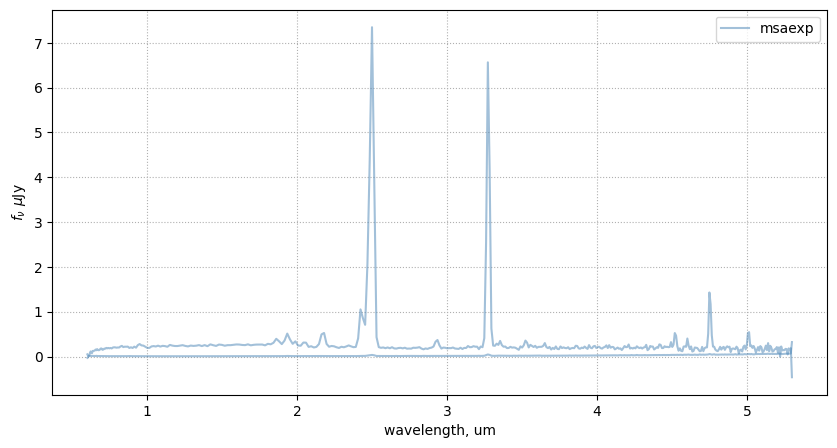

In [44]:
spec = utils.read_catalog(hdul['SPEC1D'])

fig, ax = plt.subplots(1,1,figsize=(10,5))

pl = ax.plot(spec['wave'], spec['flux'], label='msaexp', color='steelblue', alpha=0.5)
ax.plot(spec['wave'], spec['err'], color=pl[0].get_color(), alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

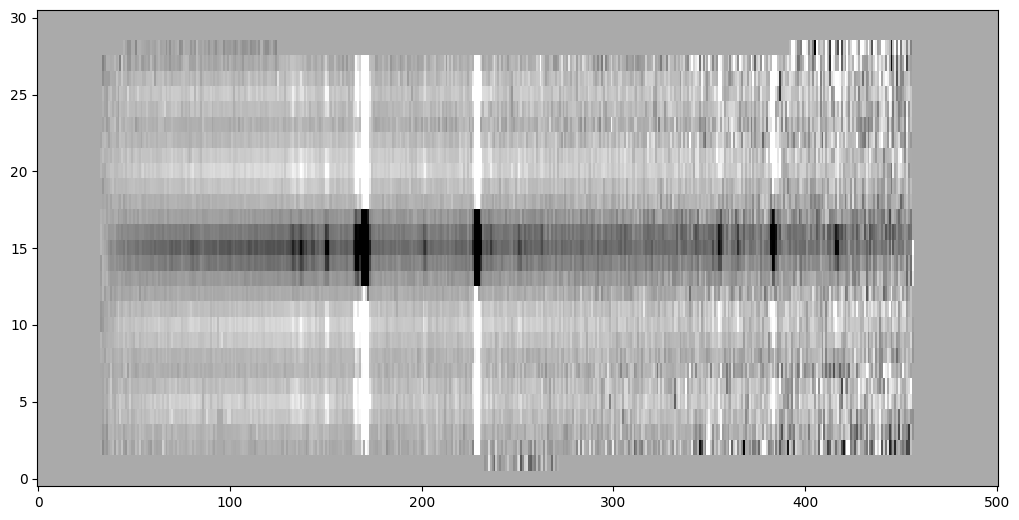

In [45]:
# 2D 
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(hdul['SCI'].data, vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')
fig.tight_layout(pad=0)

## Estimate the sky directly from the spectrum

If the sky is well determined, this can eliminate the need to take the differences of the nodded exposure

 estimate_sky                : 23 outliers > 7  / N=24966 sky pixels 


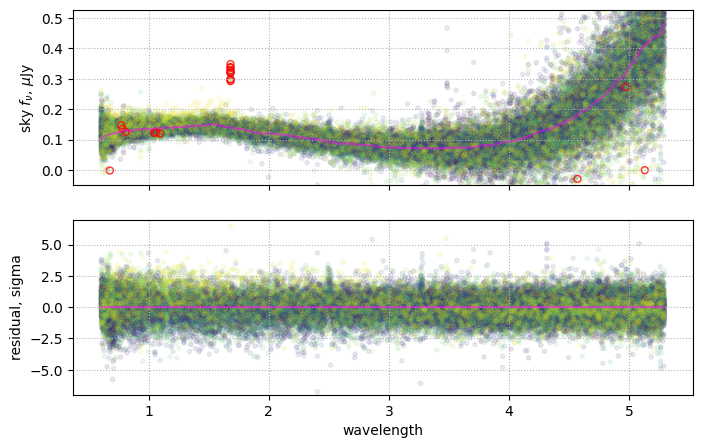

In [46]:
estimate_sky_kwargs = dict(
    mask_yslit=[[-4.5, 4.5]], # mask pixels expected to contain the source
    min_bar=0.95,
    df=81, # number of splines to fit.  Needs to be high to fit the wiggles in the sky spectrum
    high_clip=1.0,
    make_plot=True,
)  

_ = obj.estimate_sky(**estimate_sky_kwargs)

The ``data`` attribute is ``sci - sky2d`` if ``sky2d`` is available

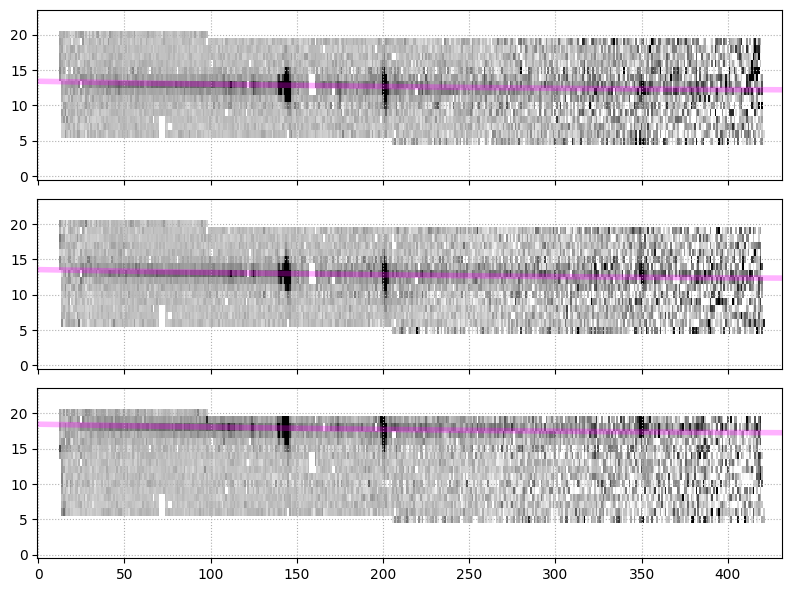

In [47]:
num = 3  # can set to obj.N to display all exposures

fig, axes = plt.subplots(num, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.data[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Flag outliers based on the cross-dispersion profile

 flag_from_profile           : 0 ( 0.0%) pixels


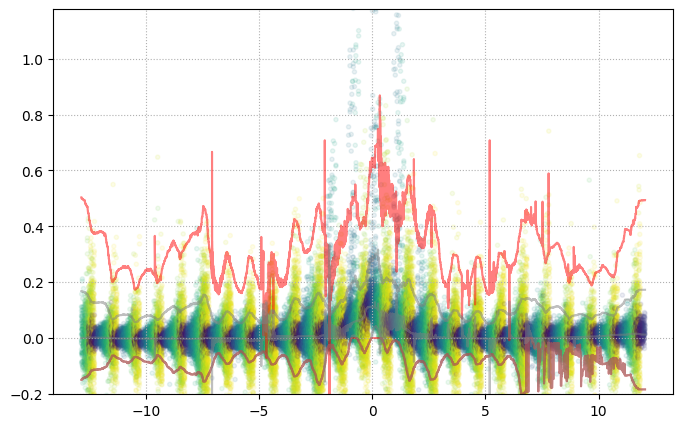

In [48]:
flag_profile_kwargs = dict(require_multiple=True, make_plot=True, grow=2, nfilt=-32)
obj.flag_from_profile(**flag_profile_kwargs)

## Turn off exposure differences and do resample and extraction again

In [49]:
obj.meta["diffs"] = False

In [50]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul_nodiff = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.31
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 31128.9
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.31


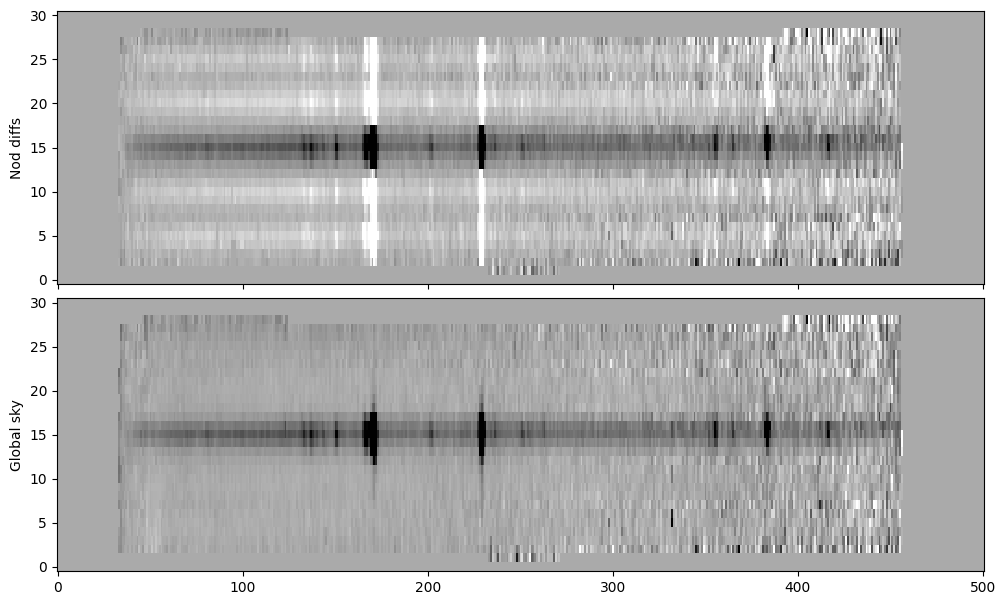

In [51]:
# 2D 
fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)
kws = dict(vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')

axes[0].imshow(hdul['SCI'].data, **kws)
axes[0].set_ylabel('Nod diffs')

axes[1].imshow(hdul_nodiff['SCI'].data, **kws)
axes[1].set_ylabel('Global sky')

fig.tight_layout(pad=0.5)

# Combination and extraction wrapped into a single script

# (2025-07-10 01:45:10.371)

slit_combine.extract_spectra(**{'target': '2561_17467', 'root': 'uncover-v3', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': True, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpos

2025-07-10 01:45:11,096 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

2025-07-10 01:45:39,637 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-10 01:45:39,638 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



uncover-v3_prism-clear_2561_17467.spec.fits
uncover-v3_prism-clear_2561_17467.pixtab.fits


2025-07-10 01:45:39,970 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-10 01:45:39,971 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



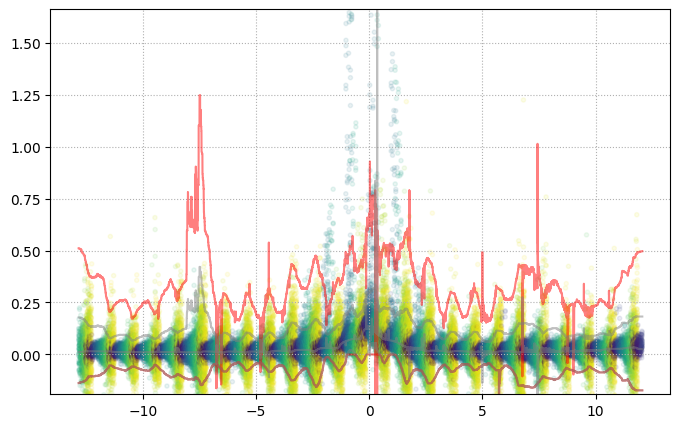

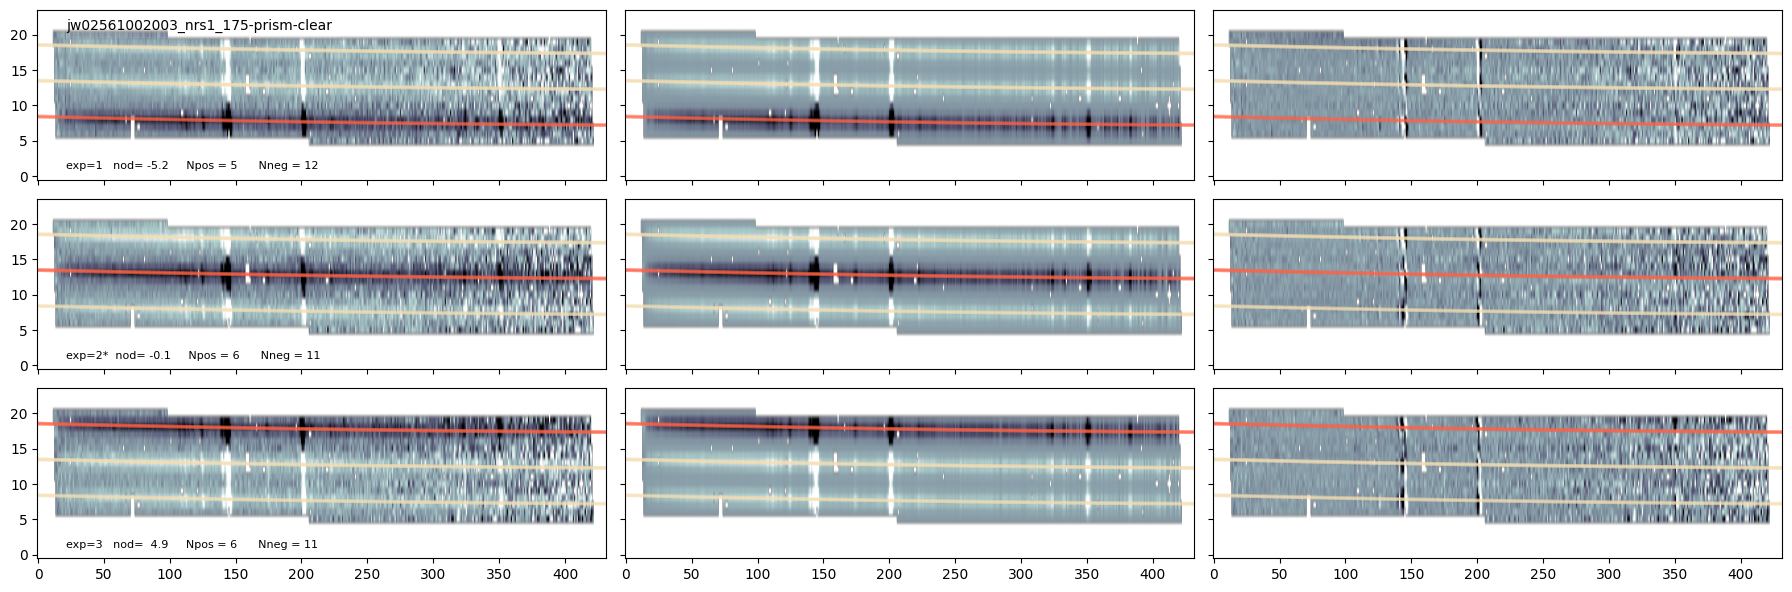

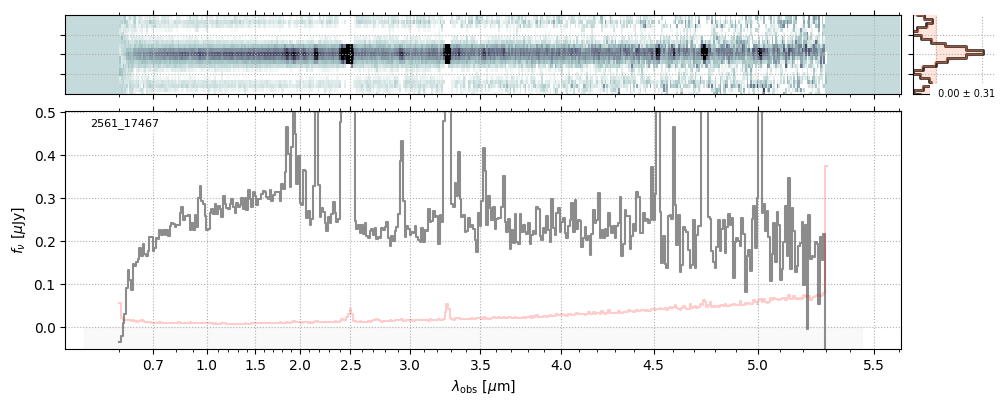

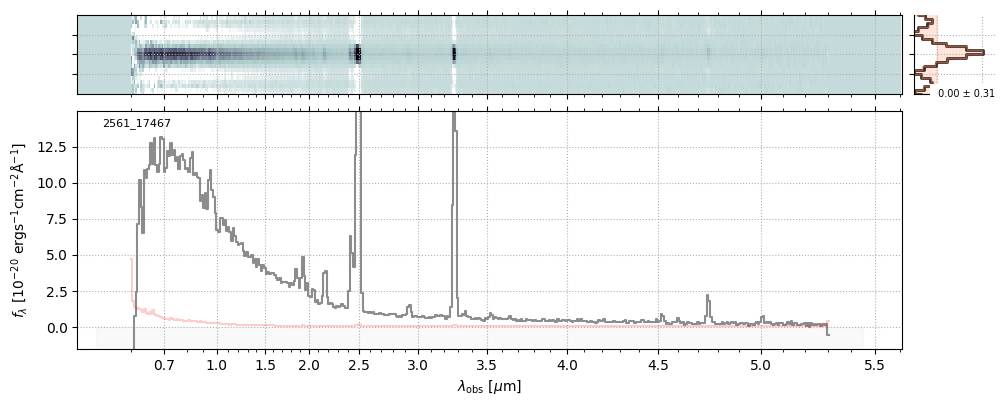

In [54]:
group_kws['diffs'] = True
group_kws['flag_profile_kwargs'] = flag_profile_kwargs

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    **group_kws,
)

# (2025-07-10 01:45:49.906)

slit_combine.extract_spectra(**{'target': '2561_17467', 'root': 'uncover-v3', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': False, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpo

2025-07-10 01:45:51,436 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

2025-07-10 01:46:13,423 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-10 01:46:13,424 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)

2025-07-10 01:46:13,754 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-10 01:46:13,755 - stpipe - WARNING - /opt/anaconda3/envs/msaexp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



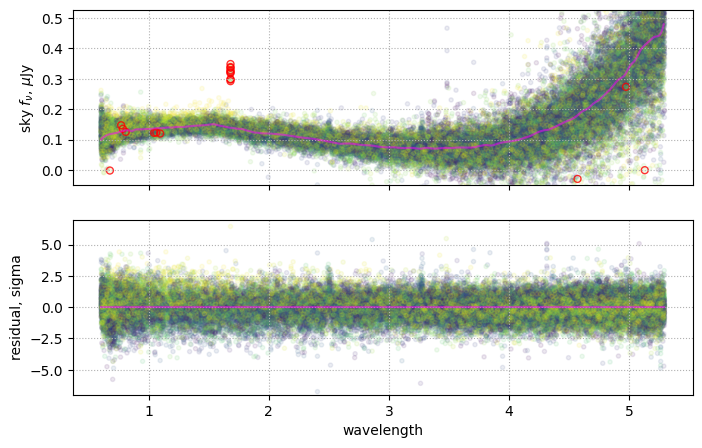

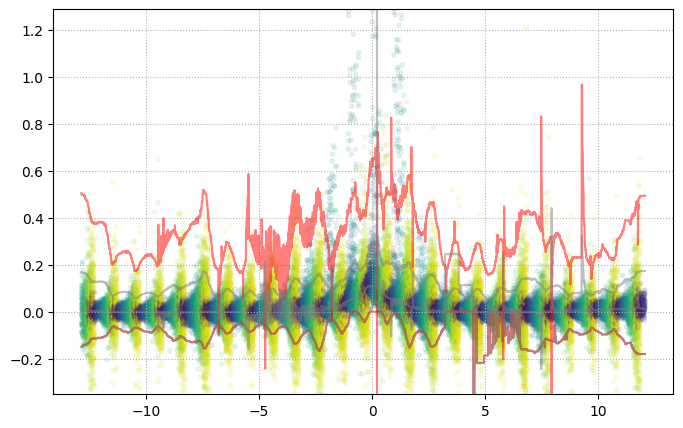

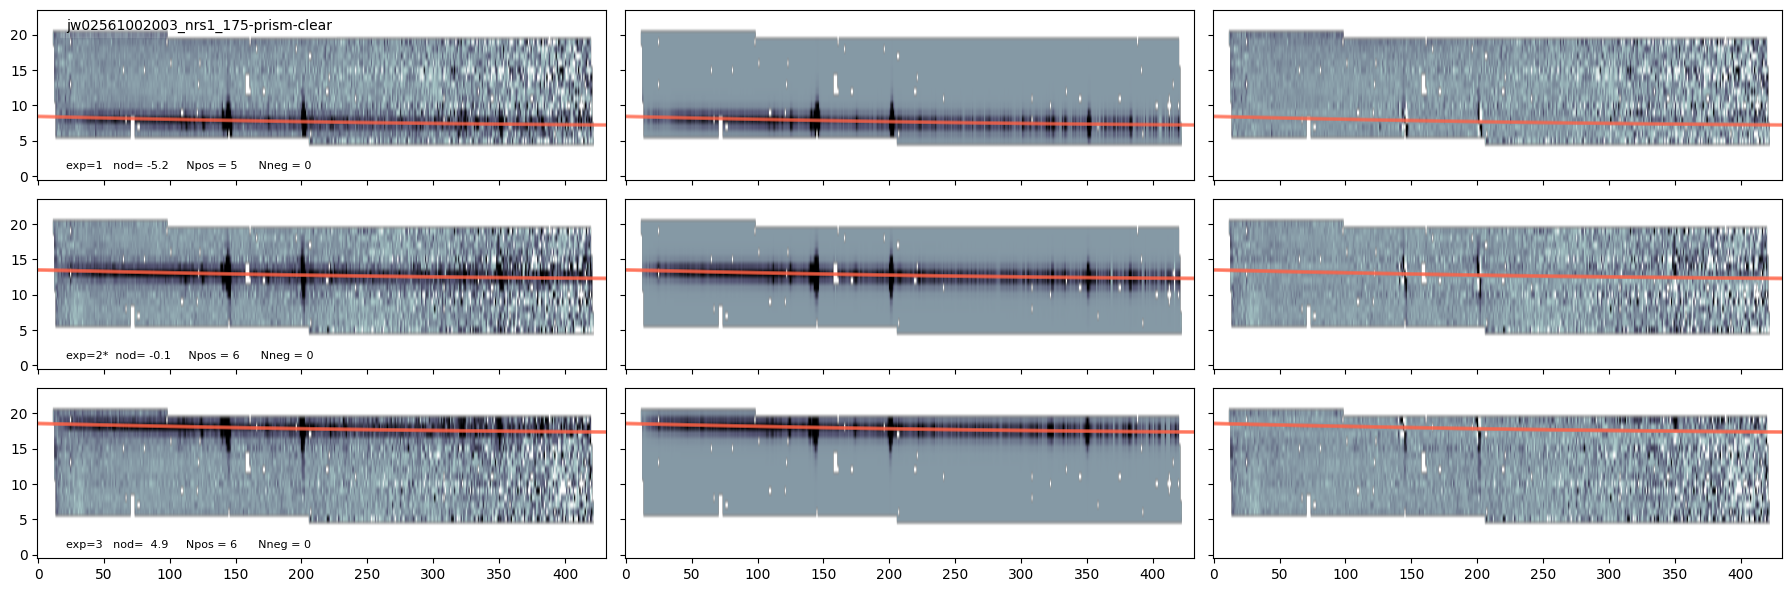

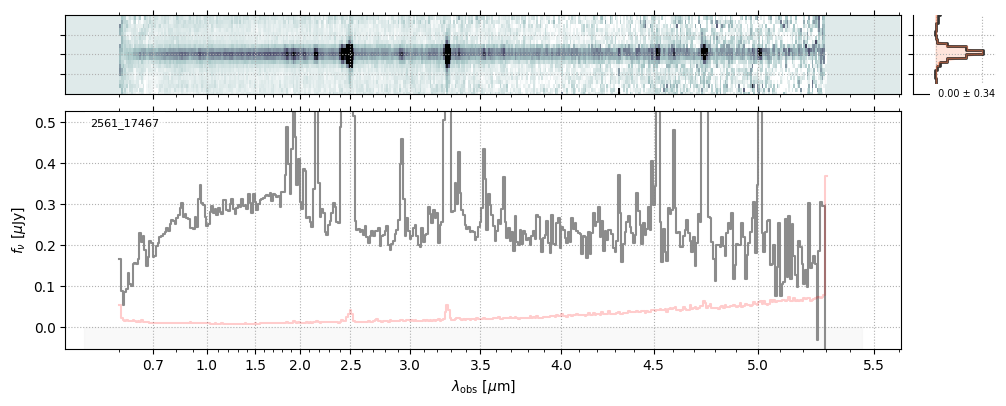

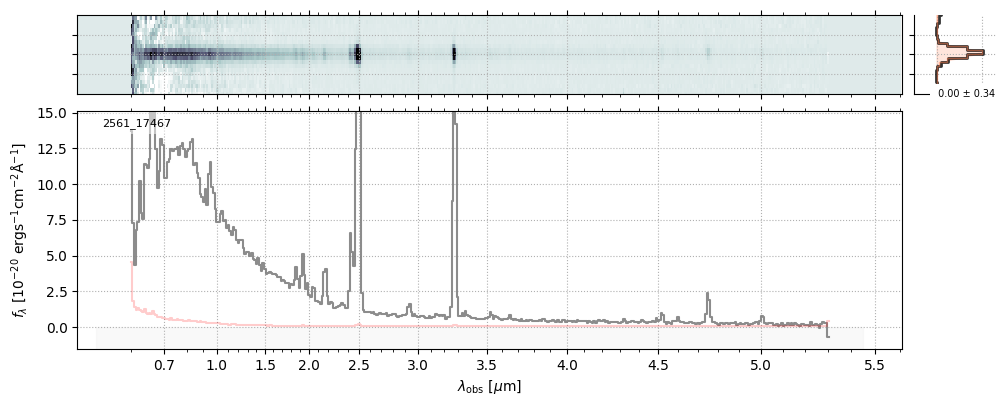

In [55]:
# With sky estimation
group_kws['diffs'] = False

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    estimate_sky_kwargs=estimate_sky_kwargs,
    **group_kws,
)

In [56]:
! ls *{target}.*

jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits
uncover-v3_2561_17467.extract.log
uncover-v3_256

# Fitting and analysis

Now go to the ``s2_specAnalysis.ipynb`` notebook for a demo on fitting the spectra for redshift, lines, etc.